In [1]:
from collections import defaultdict
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
import numpy as np
import math
from scipy.ndimage import gaussian_filter
from itertools import cycle, product
from scipy.stats import poisson
from numpy import vectorize
import multiprocessing
from joblib import Parallel, delayed
import matplotlib.pyplot as plt 

from input_functions import get_datadirs, read_input_data, concantenate_data
from data_processing import bucket_spikes, bucket_location, x_round
from maximum_likelihood_estimators import MLE_p, MLE_continuity_constraint, get_average_speeds

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
TIME_BUCKET_LENGTH = .3
LOCATION_BUCKET_LENGTH = .25 # length is 1/LOCATION_BUCKET_LENGTH

In [4]:
animal_dirs = get_datadirs()
dirs = [item for sublist in animal_dirs.values() for item in sublist]
data = read_input_data(dirs)
            
concantenated_data = concantenate_data(data)

In [5]:
# https://crcns.org/forum/using-datasets/62983963#926694452 - sampling rate of .whl is 39.06 Hz

## Bucketing Data into Time and Location Bins

In [6]:
bucketed = {}
# average time between spikes is 0.002s, time between location measurements is 0.02s
dt = 0.1
dL = 0.01
times = [dt]
lengths = [dL]
for time, length, directory in product(times, lengths, dirs):
    if (time, length, directory) not in bucketed:
        bucketed_spikes = bucket_spikes(concantenated_data[directory], time)
        locs, bucketed_locs = bucket_location(data[directory]['location'], time, length)

        bucketed_spikes['location'] = bucketed_locs[0]
        bucketed_spikes['unbucketed_location'] = locs[0]
        bucketed_spikes = bucketed_spikes.dropna()
        bucketed[time, length, directory] = bucketed_spikes

In [7]:
df = bucketed[0.1, 0.01, 'data/ec013.40/ec013.719/']

spikes = np.array(df.loc[:,df.columns[:-2]])
spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])

T = len(df) * dt
L = int(df.location.max() + 5)
xaxis = np.arange(0,L,dL) + dL/2 # center of bins
find_nearest = np.vectorize(lambda x: fn(xaxis, x))
M = spikes.shape[1]

X = np.array(df.unbucketed_location)
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])

## Plotting Trajectory with Spikes Overlayed

In [8]:
%matplotlib inline
def plot_spikes_for_neuron(df, neuron):
    plt_df = df.copy(deep=True)
    plt_df.index = plt_df.index.total_seconds()
    plt_df.location.plot()
    cycol=cycle('bgrcmky')
    spikes_at_location = plt_df.loc[plt_df[neuron][plt_df[neuron] > 0].index]
    plt.scatter(spikes_at_location.index, spikes_at_location.location.values)
    plt.ylabel('Location in cm')
    plt.xlabel('Time in s')
    plt.title('Time vs Location for Neuron {}'.format(neuron))
    plt.show()

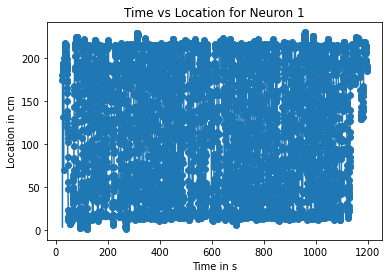

In [9]:
neurons = [1]#,10,20,30,40,50,60,70,80]
%matplotlib inline

for neuron in neurons:
    plot_spikes_for_neuron(df, neuron)

## Calculating Place Fields

In [10]:
def poisson_mean(df, i, x, time_bucket_length):
    return df[df.location==x][i].sum()/(len(df[df.location==x]) * time_bucket_length)

def calculate_poisson(df, locations, time_bucket_length):
    poisson = {}
    for x_k in locations:
        for i in list(df.columns[:-2]):
            pm = poisson_mean(df, i, x_k, time_bucket_length)
            poisson[i, x_k] = pm
    return poisson

def calculate_smoothed_poisson(df, locations, time_bucket_length):
    poisson_dic = calculate_poisson(df, locations, time_bucket_length)
    poisson_series = pd.Series(poisson_dic).reset_index()
    poisson_series.columns = ['neuron', 'location', 'poisson_mean']
    poisson_series = poisson_series.sort_values(['neuron', 'location']).reset_index(drop=True)
    estimated_place_fields = np.array(poisson_series.pivot(index='neuron',columns='location'))
    smoothed_place_fields = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=40), 1, estimated_place_fields)
    dic = {}
    xaxis = sorted(locations)
    for neuron in range(smoothed_place_fields.shape[0]):
        for i in range(smoothed_place_fields.shape[1]):
            dic[neuron, xaxis[i]] = smoothed_place_fields[neuron,i]
    return dic

## Plotting Place Fields by Neuron

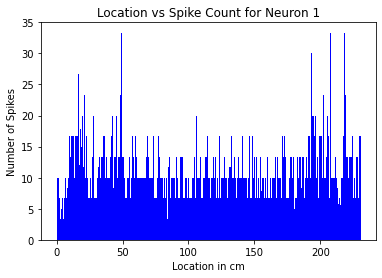

In [11]:
%matplotlib inline
poisson_dic = calculate_poisson(df, list(set(df.location)), TIME_BUCKET_LENGTH)
df_pos = pd.DataFrame(poisson_dic.values(), index=poisson_dic.keys())
df_pos = df_pos.reset_index()
df_pos.columns = ['neuron', 'location', 'spikes']
cycol=cycle('bgrcmky')
for neuron in neurons:
    vals = df_pos[df_pos['neuron'] == neuron].sort_values('location')
    plt.bar(vals.location, vals.spikes, color=next(cycol), label=str(neuron))
    plt.ylabel('Number of Spikes')
    plt.xlabel('Location in cm')
    plt.title('Location vs Spike Count for Neuron {}'.format(neuron))
    plt.show()

## Mean Squared Error calculators

In [12]:
def MSE(df, time_bucket_length, predict=True):
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    error = 0
    locations = list(set(df.location))
    poisson = calculate_smoothed_poisson(train, locations, time_bucket_length)
    neurons = list(df.columns[:-2])
    if predict:
        predictions = []
        for index, row in df.iterrows():
            x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
            predictions.append((index, x_pred))
            if len(predictions) >= len(train) and len(predictions) <= len(train) + len(val):
                error += (row.iloc[-1] - x_pred) ** 2
        error /= len(val)
        return error, predictions
    for index, row in val.iterrows():
        x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
        error += (row.iloc[-1] - x_pred) ** 2
    error /= len(val)
    return error

def MSE_continuity_constraint(df, time_bucket_length, K=15, V=20, d=0.5, predict=True):
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    error = 0
    locations = list(set(df.location))
    average_speed = get_average_speeds(train, locations)
    poisson = calculate_smoothed_poisson(train, locations, time_bucket_length)
    neurons = list(df.columns[:-2])
    if predict:
        predictions = []
        for index, row in df.iterrows():
            x_pred = 0
            if len(predictions) == 0:
                x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
            else:
                x_pred = MLE_continuity_constraint(neurons, row[:-2], average_speed,
                                               locations, predictions[-1][1], K, V, d, time_bucket_length, poisson)
            predictions.append((index, x_pred))
            if len(predictions) >= len(train) and len(predictions) <= len(train) + len(val):
                error += (row.iloc[-1] - x_pred) ** 2
        error /= len(val)
        return error, predictions
    pred_count = 0
    for index, row in val.iterrows():
        x_pred = 0
        if pred_count == 0:
            x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
        else:
            x_pred = MLE_continuity_constraint(neurons, row[:-2], average_speed,
                                           locations, predictions[-1][1], K, V, d, time_bucket_length, poisson)
        error += (row.iloc[-1] - x_pred) ** 2
        pred_count += 1
    error /= len(val)
    return error

def calculate_MSE(time, length, directory):
    if (time, length, directory) not in bucketed:
        bucketed_spikes = bucket_spikes(concantenated_data[directory], time)
        locs, bucketed_locs = bucket_location(data[directory]['location'], time, length)
        bucketed_locs[0] = bucketed_locs[0].apply(lambda x: np.nan if x == -1 or x == 0 else x)
        locs[0] = locs[0].apply(lambda x: np.nan if x == -1 or x == 0 else x)
        bucketed_spikes['location'] = bucketed_locs[0]
        bucketed_spikes['unbucketed_location'] = locs[0]
        bucketed_spikes = bucketed_spikes.dropna()
        bucketed[time, length, directory] = bucketed_spikes

    df = bucketed[time, length, directory]
    error, _ = MSE(df, time)
    error_cc, _ = MSE_continuity_constraint(df, time)
    print(time, length, error, error_cc)
    print("Time = {}s, length = {}cm, error = {:.2f}, error_cc = {:.2f}".format(time, length, error, error_cc))
    return [time, length, error, error_cc]

In [13]:
error_cc, predictions_cc = MSE_continuity_constraint(df, dt)
error, predictions = MSE(df, dt)
predictions_cc = pd.DataFrame(predictions_cc)
predictions = pd.DataFrame(predictions)
predictions["cc"] = predictions_cc[1]
predictions.columns = ['time', 'MLE', 'MLE CC']
predictions = predictions.set_index('time', drop=True)
predictions['Ground Truth'] = df["unbucketed_location"]

/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


KeyboardInterrupt: 

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
predictions.iloc[msk:msk+1000].plot.line(title="MLE vs MLE CC vs Ground Truth - Test Segment\n {}s intervals, {:.2f}cm spacing".format(0.5, 0.05))
plt.show()